<a href="https://colab.research.google.com/github/zainoor/M7-DataMining/blob/main/TugasM7_KDM_Ramadhan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

In [ ]:
# Load the fraud dataset
print("Loading fraudTrain.csv dataset...")
df = pd.read_csv("fraudTrain.csv")
print(f"Dataset shape: {df.shape}")

# Preprocess the dataset: Select numerical features and handle NaN/inf values
print("\nPreprocessing data for clustering...")
# Select numerical features relevant for clustering
numerical_features = ['amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']
df_selected = df[numerical_features].copy()

# Check for NaN or inf values
print("Checking for NaN or inf values in the selected features...")
nan_mask = df_selected.isna().any(axis=1)
inf_mask = np.isinf(df_selected).any(axis=1)
invalid_mask = nan_mask | inf_mask

# Impute NaN values with the median of each column
if nan_mask.sum() > 0:
    print(f"Found {nan_mask.sum()} rows with NaN values. Imputing with column medians...")
    for col in numerical_features:
        median_val = df_selected[col].median()
        df_selected[col] = df_selected[col].fillna(median_val)
else:
    print("No NaN values found in the selected features.")

# Impute inf values with the maximum finite value of each column
if inf_mask.sum() > 0:
    print(f"Found {inf_mask.sum()} rows with inf values. Imputing with max finite values...")
    for col in numerical_features:
        finite_vals = df_selected[col][~np.isinf(df_selected[col])]
        max_finite = finite_vals.max() if len(finite_vals) > 0 else 0
        min_finite = finite_vals.min() if len(finite_vals) > 0 else 0
        df_selected[col] = df_selected[col].replace(np.inf, max_finite)
        df_selected[col] = df_selected[col].replace(-np.inf, min_finite)
else:
    print("No inf values found in the selected features.")

# Verify dataset size after imputation
print(f"Dataset shape after imputation: {df_selected.shape}")
assert df_selected.shape[0] >= 100000, f"Dataset size {df_selected.shape[0]} is less than 100,000 after preprocessing!"

# Convert to numpy array
data = df_selected.values

# Standardize the features
scaler = StandardScaler()
data = scaler.fit_transform(data)
print(f"Preprocessed dataset shape: {data.shape}")

Loading fraudTrain.csv dataset...
Dataset shape: (100002, 23)

Preprocessing data for clustering...
Checking for NaN or inf values in the selected features...
Found 47081 rows with NaN values. Imputing with column medians...
No inf values found in the selected features.
Dataset shape after imputation: (100002, 7)
Preprocessed dataset shape: (100002, 7)


In [ ]:
# 1. KMeans Clustering
print("Running KMeans...")
start_time = time.time()
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(data)
kmeans_time = time.time() - start_time

Running KMeans...


In [ ]:
# 1. KMeans Clustering
print("Running KMeans...")
start_time = time.time()
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(data)
kmeans_time = time.time() - start_time

# KMeans outputs
print("KMeans Centroids (standardized):")
print(kmeans.cluster_centers_)
print("KMeans Cluster Assignments (first 10 samples):")
print(kmeans_labels[:10])
print(f"KMeans Processing Time: {kmeans_time:.2f} seconds")

Running KMeans...
KMeans Centroids (standardized):
[[ 0.39538714  0.66795757  0.77884709 -0.09621287  1.214616    0.67804982
   0.79129486]
 [ 0.14987127  0.69065943 -2.60634974  0.04522275  0.01602573  0.69919644
  -2.59859635]
 [-0.11404378  0.20033352  0.21107349 -0.16792132 -0.25224084  0.19449463
   0.20526876]
 [ 0.15125367 -0.89559606 -0.73835626  6.58306647 -0.0126897  -0.88495392
  -0.72838275]
 [ 0.07176325 -1.87208892 -0.18628319  0.03120739  0.05994878 -1.85967925
  -0.17573625]]
KMeans Cluster Assignments (first 10 samples):
[2 2 1 2 2 2 2 2 2 2]
KMeans Processing Time: 0.27 seconds


Running Hierarchical Agglomerative Clustering...


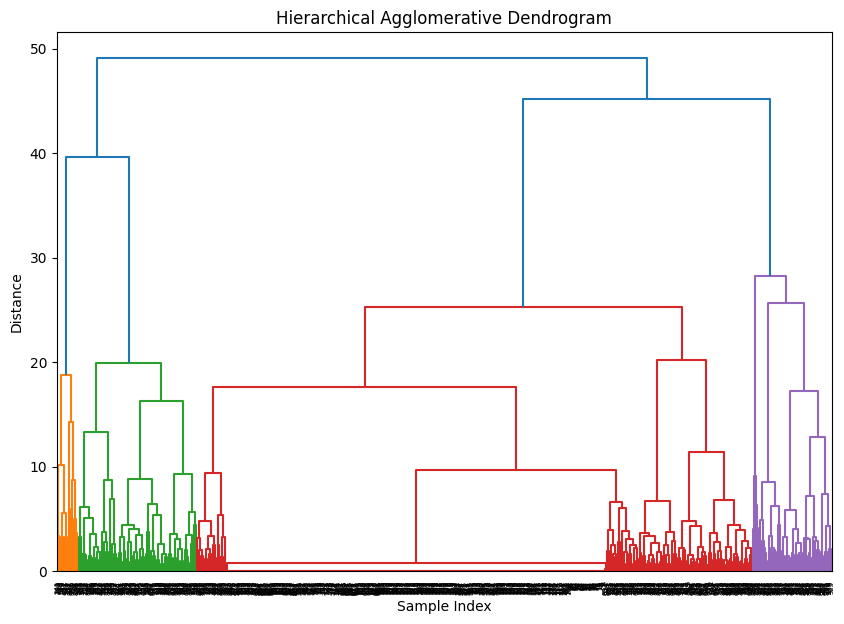

Hierarchical Agglomerative Processing Time: 0.02 seconds


In [ ]:
# 2. Hierarchical Agglomerative Clustering (Dendrogram)
print("Running Hierarchical Agglomerative Clustering...")
# Subsample for dendrogram to avoid memory issues (dendrogram visualization is heavy)
subset_data = data[np.random.choice(data.shape[0], 1000, replace=False)]
start_time = time.time()
Z = linkage(subset_data, method='ward')
hierarchical_time = time.time() - start_time

# Plot and save dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Hierarchical Agglomerative Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
# plt.savefig("dendrogram.png")
plt.show()
# print("Dendrogram saved as 'dendrogram.png'")
print(f"Hierarchical Agglomerative Processing Time: {hierarchical_time:.2f} seconds")

In [ ]:
# 3. Kohonen SOM (Self-Organizing Map) - Custom Implementation
print("Running Kohonen SOM...")
class KohonenSOM:
    def __init__(self, map_size, input_dim, learning_rate=0.1, sigma=None):
        self.map_size = map_size  # (rows, cols)
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.sigma = sigma if sigma is not None else max(map_size) / 2
        # Initialize weights randomly
        self.weights = np.random.rand(map_size[0], map_size[1], input_dim)

    def find_bmu(self, x):
        # Find Best Matching Unit (BMU) using Euclidean distance
        distances = np.linalg.norm(self.weights - x, axis=2)
        return np.unravel_index(np.argmin(distances), self.map_size)

    def update_weights(self, x, bmu, iteration, max_iterations):
        # Update weights based on neighborhood and learning rate
        lr = self.learning_rate * (1 - iteration / max_iterations)
        sigma = self.sigma * (1 - iteration / max_iterations)
        for i in range(self.map_size[0]):
            for j in range(self.map_size[1]):
                distance_to_bmu = np.linalg.norm(np.array([i, j]) - np.array(bmu))
                if distance_to_bmu < sigma:
                    influence = np.exp(-distance_to_bmu**2 / (2 * sigma**2))
                    self.weights[i, j] += lr * influence * (x - self.weights[i, j])

    def fit(self, data, num_iterations):
        for iteration in range(num_iterations):
            # Use a random sample for training
            x = data[np.random.randint(0, len(data))]
            bmu = self.find_bmu(x)
            self.update_weights(x, bmu, iteration, num_iterations)

    def predict(self, data):
        labels = np.zeros(len(data), dtype=int)
        for i, x in enumerate(data):
            bmu = self.find_bmu(x)
            labels[i] = bmu[0] * self.map_size[1] + bmu[1]  # Convert 2D index to 1D label
        return labels

Running Kohonen SOM...


In [ ]:
# Train SOM
start_time = time.time()
som = KohonenSOM(map_size=(5, 5), input_dim=data.shape[1])
som.fit(data, num_iterations=1000)
som_labels = som.predict(data)
som_time = time.time() - start_time

In [ ]:
# SOM outputs
print("Kohonen SOM Weights:")
print(som.weights)
print("SOM Cluster Assignments (first 10 samples):")
print(som_labels[:10])
print(f"Kohonen SOM Processing Time: {som_time:.2f} seconds")

Kohonen SOM Weights:
[[[ 0.55553249  1.10657495 -2.37143954  0.02532822  0.02530846
    1.10518474 -2.36039696]
  [ 0.17102023 -0.13603953 -2.17428243  0.59262134  0.15549385
   -0.1077818  -2.1678162 ]
  [-0.13002455 -1.23106243 -1.28516348  1.38369583 -0.21989381
   -1.17677273 -1.26015658]
  [-0.25165705 -1.67817465 -0.52527976  0.33539678 -0.60854434
   -1.6397283  -0.50239107]
  [-0.08313644 -2.06558362 -0.195261    0.15472297  0.23403203
   -2.04586822 -0.15796033]]

 [[ 1.58035074  1.03180492 -1.39560592 -0.01366968  0.62185931
    1.06583824 -1.38948264]
  [ 0.31647709  0.14765664 -0.89696203  0.05851253  0.54481446
    0.19470729 -0.89637669]
  [-0.19289351 -0.14199347 -0.26694466 -0.06221216 -0.17995136
   -0.12300478 -0.27012865]
  [-0.17704103 -0.95333868 -0.27807516  0.0491264   0.34143021
   -0.91315125 -0.27133018]
  [-0.09553394 -1.51161552 -0.06553224 -0.01542552  0.64231386
   -1.50367528 -0.04742767]]

 [[ 0.35311064  1.1168544  -0.50497194  0.02183638  0.51960636
  